# Load FIRE Data


In [216]:
# Import the main analysis module
import gizmo_analysis as gizmo

In [217]:
# Choose the simulation directory
simulation_directory = '/home/jovyan/fire2/m12i'

In [218]:
# read star particles and gas cells at z = 0
part = gizmo.io.Read.read_snapshots(['star', 'dark'], 'redshift', 0, simulation_directory)


# in utilities.simulation.Snapshot():
* reading:  home/jovyan/fire2/m12i/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/jovyan/fire2/m12i/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 57060074 particles
    star      (id = 4): 13976485 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star', 'dark']

* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

! cannot find MUSIC config file:  home/jovyan/fire2/m12i/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties


# in gizm

# Extract parameters from FIRE

In [662]:
# Display keys
print( part.keys() )
print( part['star'].keys() )
print( part['dark'].keys() )

dict_keys(['star', 'dark'])
dict_keys(['position', 'mass', 'massfraction', 'id.child', 'id.generation', 'id', 'potential', 'form.scalefactor', 'velocity'])
dict_keys(['position', 'mass', 'id.child', 'id.generation', 'id', 'potential', 'velocity'])


In [663]:
# Declare parameters for star and dark matter particles
starPos = part['star'].prop('host.distance') # star position in kpc
starMass = part['star']['mass']              # star mass in Msun
starVel = part['star'].prop('host.velocity') # star velocity in km/s

darkPos = part['dark'].prop('host.distance') # dark position in kpc
darkMass = part['dark']['mass']              # dark mass in Msun
darkVel = part['dark'].prop('host.velocity') # dark velocity in km/s

In [664]:
# Temporary unit conversion from km/s to kpc/Gyr (ie. pc/Myr)
kmsInPcMyr = 1.0227121655399913
starVel = starVel * kmsInPcMyr
darkVel = darkVel * kmsInPcMyr

# Graph density plots and find coefs

In [665]:
# Import modules for graphing 
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Import modules for curve fitting
import scipy
from scipy.optimize import curve_fit

Note: in both graphing codes below:
* edges = bin edges of the histogram computed for the radial data
* edges[1:] = all the bin edges except for the lower edge of the first bin
* edges[:-1] = all bin edges except for the upper edge of the last bin

In [666]:
# Define the bin edges
rmin = 0  # minimum radius
rmax = 200  # maximum radius
bins = 200  # number of bins

### Star density profile

/tmp/ipykernel_518/3510097798.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(rmin, rmax)


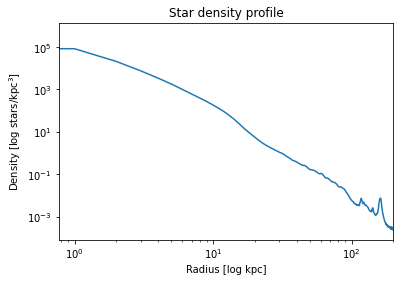

In [667]:
# Compute radial distance
starRadial = np.sqrt((starPos[:,0])**2 + (starPos[:,1])**2 + (starPos[:,2])**2)

# Compute the density profile
counts, edges = np.histogram(starRadial, bins=bins, range=(rmin, rmax))
volume = 4.0/3.0 * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))
density = counts / volume

# Plot the density profile
fig, ax = plt.subplots()
ax.loglog(edges[:-1], density)
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
plt.title('Star density profile')
plt.show()

### Calculate gamma from the star population

In [668]:
# Objective function
def objective(r, gamma):
 return np.power(r,-gamma)

# Call curve_fit 
popt, pcov = curve_fit(objective, edges[1:], density)

# Assign gamma from the stellar data fit
gamma = popt[0]
print("Gamma = ", gamma)

# Try log fitting instead

Gamma =  -0.5617534010051383


### Calculate beta from the star population

In [669]:
# Import modules to calculate beta
import beta as b

# Call beta function to calculate anisotropy from 3d pos and vel arrays
beta = b.beta(starPos, starVel)
print("Beta = ", beta)

Beta =  0.12881259096512354


### Dark matter density profile

/tmp/ipykernel_518/833199444.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(rmin, rmax)


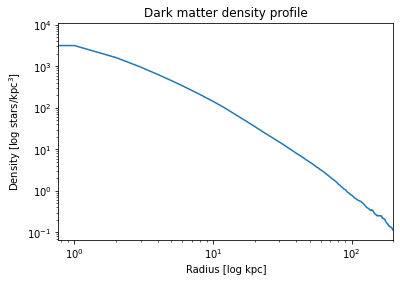

In [670]:
# Compute radial distance
darkRadial = np.sqrt((darkPos[:,0])**2 + (darkPos[:,1])**2 + (darkPos[:,2])**2)

# Compute the density profile
counts, edges = np.histogram(darkRadial, bins=bins, range=(rmin, rmax))
volume = 4.0/3.0 * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))
density = counts / volume

# Plot the density profile
fig, ax = plt.subplots()
ax.loglog(edges[:-1], density)
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
plt.title('Dark matter density profile')
plt.show()

### Calculate alpha from dark matter population

In [671]:
# Objective function
def objective(r, gammaDark):
 return np.power(r,-gammaDark)

# Call curve_fit 
popt, pcov = curve_fit(objective, edges[1:], density)

# Assign gamma
gammaDark = popt[0]

# Calculate alpha 
alpha = gammaDark - 2
print("Alpha = ", alpha)

Alpha =  -2.3797642325714556


**Alpha:**  

$\phi(r) =  \frac{v_0^2}{\alpha}\left(\frac{a}{r}\right)^\alpha$  

with $-1 \le \alpha \le 1$  
($\alpha \ge -2$ permited)

$\alpha = 0$: particles orbiting point mass  
$\alpha = 1$: satellites moving in a large-scale mass distribution with a flat rotation curve  
$\alpha = \gamma - 2$: satellites track the total gravitating mass  
  
**Beta:**  

$\beta = 1 - \sigma_t^2 / \sigma_r^2$  

$\beta \rightarrow \infty$: circular orbit model  
$\beta = 1$: purely radial orbits  
$\beta = 0$: isotropic case  

**Gamma:**  

$\rho(r) \propto r^{-\gamma}$  

$\frac{d\log \rho}{d\log r} = -\gamma$

In [672]:
print("Calculated alpha: ", alpha, "   Expected: 0.55")
print("Calculated beta:  ", beta,  "   Expected: 0 to infinity")
print("Calculated gamma: ", gamma, "   Expected: 2.6")

Calculated alpha:  -2.3797642325714556    Expected: 0.55
Calculated beta:   0.12881259096512354    Expected: 0 to infinity
Calculated gamma:  -0.5617534010051383    Expected: 2.6


### Calculate and graph beta as a function of distance

In [673]:
# Call binned beta function 
betaArr = b.beta_r(starPos, starVel, n_bins=100, rmax=rmax)

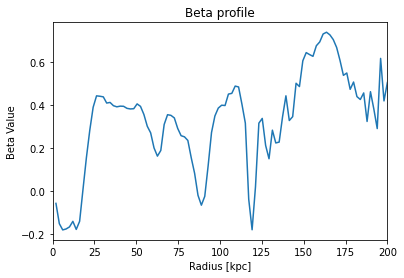

In [674]:
# Graph binned beta
fig, ax = plt.subplots()
ax.plot(betaArr[0][1:], betaArr[1])
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Beta Value')
ax.set_xlim(rmin, rmax)
plt.title('Beta profile')
plt.show()

In [675]:
# Set beta to use beta array instead of float
beta = betaArr[1]

# Use mass estimator

In [685]:
# Import mass estimator 
import mass_estimators

In [686]:
# Force values for now
alpha = 0.5
gamma = 2.6

In [687]:
# Call the profile estimator 
mass = mass_estimators.mass_estimator_profile(alpha, beta, gamma, starPos, starVel, rmin, rmax, nbins=len(beta))

In [688]:
# Assign radius and mass outputs
radius = mass[0]  # galactocentric distance bins [kpc]
mass_v = mass[1]  # enclosed mass profile computed with 3d velocities [Msun/1E10]
mass_vr = mass[2] # enclosed mass profile computed with radial velocities [Msun/1E10]

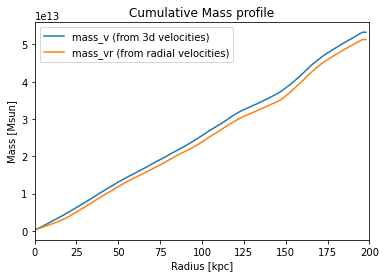

In [689]:
# Plot the mass profile in cummulative shells
fig, ax = plt.subplots()
ax.plot(radius, np.cumsum(mass_v[1:])*1E10, label='mass_v (from 3d velocities)')
ax.plot(radius, np.cumsum(mass_vr[1:]*1E10), label='mass_vr (from radial velocities)')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Mass [Msun]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Cumulative Mass profile')
plt.show()

# Compare to FIRE mass

In [690]:
# Declare function to calculate cumulative mass
def cumulative(mass, pos, n_bins, rmax):
    dr = np.linspace(0, rmax, n_bins)
    r = (pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)**0.5
    mass_dr = np.zeros(len(dr)-1)
    for i in range(len(dr)-1):
        index = np.where((r<dr[i+1]) & (r>dr[i]))
        mass_dr[i] = np.sum(mass[index])
    return dr, mass_dr

In [691]:
# Calculate FIRE cumulative mass
fireCumulative = cumulative(starMass, starPos, n_bins=100, rmax=rmax)
fireRadius = fireCumulative[0]
fireMass = fireCumulative[1]

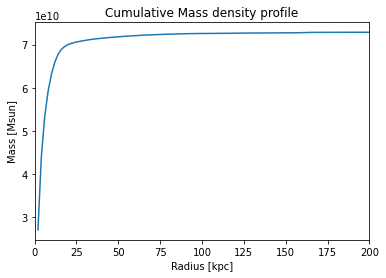

In [692]:
# Plot the expected mass from FIRE
fig, ax = plt.subplots()
ax.plot(fireRadius[1:], np.cumsum(fireMass))
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Mass [Msun]')
ax.set_xlim(rmin, rmax)
plt.title('Cumulative Mass density profile')
plt.show()

# Combined mass density profile

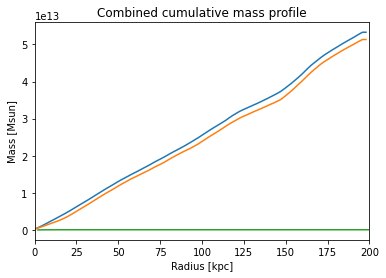

In [693]:
# Plot the expected mass from FIRE
fig, ax = plt.subplots()
ax.plot(radius, np.cumsum(mass_v[1:])*1E10, label='mass_v (from 3d velocities)')
ax.plot(radius, np.cumsum(mass_vr[1:])*1E10, label='mass_vr (from radial velocities)')
ax.plot(fireRadius[1:], np.cumsum(fireMass), label='fireMass (from FIRE data)')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Mass [Msun]')
ax.set_xlim(rmin, rmax)
plt.title('Combined cumulative mass profile')
plt.show()